```
a. Samuel
b. 2020-06-25
c. With minimal feature engineering, I trained a gradient boosting model to predict the outcome with an AUC higher than 0.825
d. 0.842
```

# Step 1. Download, unzip, and load data into pandas DataFrame

In [44]:
# !unzip data.zip

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

train = pd.read_csv('train.csv')

# Step 2. Inspect DataFrame

In [46]:
def count_nulls(df):
    """
    take in a pandas dataframe and print
    a count of the null values for each column
    """
    print("Null Count\n")
    for col in df.columns:
        print(col + ':',df[col].isnull().sum())
        
count_nulls(train)

Null Count

age: 0
cost_of_ad: 0
device_type: 0
gender: 269
in_initial_launch_location: 0
income: 0
n_drivers: 0
n_vehicles: 0
prior_ins_tenure: 0
outcome: 0


# Step 3. EDA

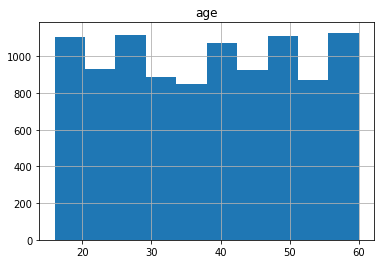

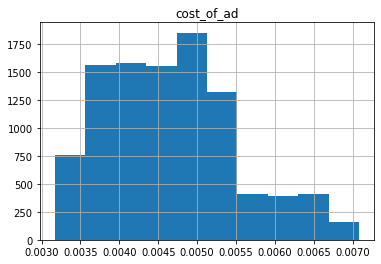

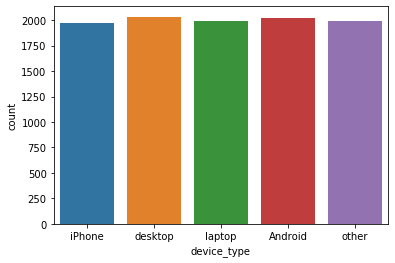

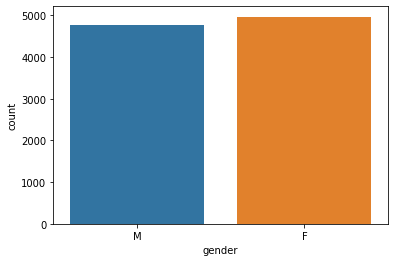

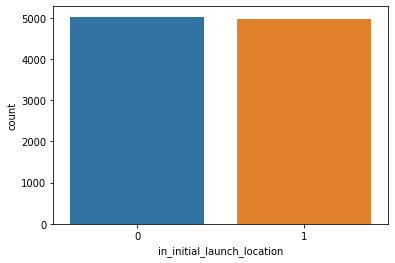

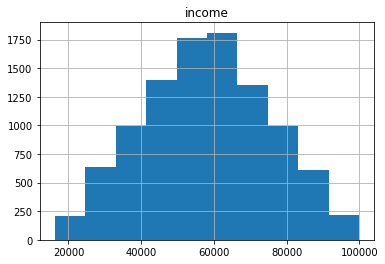

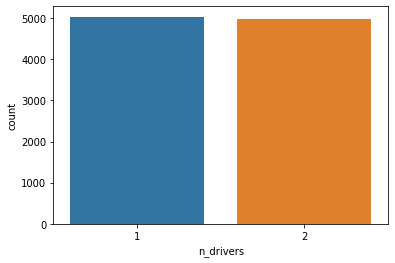

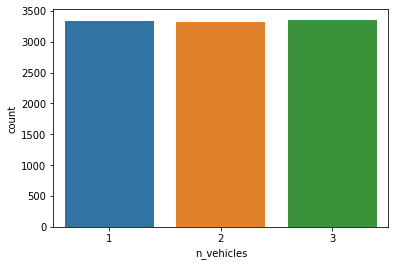

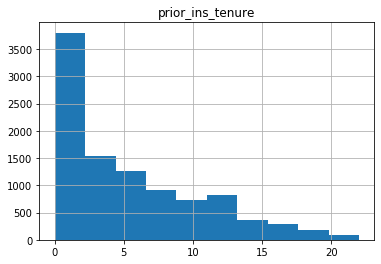

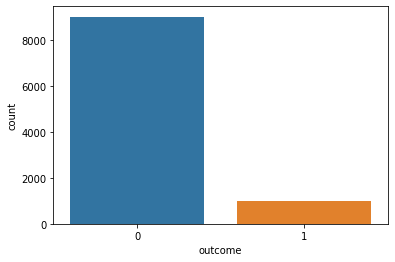

In [47]:
def plot_columns(df):
    """
    take in a DataFrame and
    return show a scrolling plot of each column
    as a bar chart or histogram
    """
    for i, col in enumerate(df.columns):
        if len(df[col].unique()) < 10:
            sns.countplot(df[col])
        else:
            df[col].hist()
            plt.title(col)
        plt.show()

plot_columns(train)

>**Distributions appear normal and even across categorical variables except outcome.**

# Step 4. Feature Engineering

In [48]:
def add_dummy_columns(df, column):
    """
    take in a DataFrame and a column
    and return the dummy columns concatenated
    to the DataFrame
    """
    drop_first = False
    if len(df[column].unique()) == 2:
        drop_first = True
    cols = pd.get_dummies(train[column], prefix=column, 
                          drop_first=drop_first, dummy_na=True)
    
    return pd.concat([df,cols], 1)

# iterate through categorical columns
# and add dummies
for col in ['device_type', 'gender']:
    train = add_dummy_columns(train, col)

df = train.drop(['device_type', 'gender'], 1)


## Create functions for bucketized features if needed

In [49]:
# def gen_features_range(df, col):
#     """
#     take in a DataFrame and column
#     and insert new columns of an iteratable range
#     """
#     last = 0
#     for i in range(df[col].min(), df[col].max(), (df[col].max() - df[col].min())//10):
#         df[str(last) + '<' + col + '<=' + str(i)] = np.where(
#             (last < df[col]) & (df[col] <= i), 1,0)
#         last = i

# for feat in ['age']:
#     gen_features_range(df, feat)

# # prior insurance
# df['prior_ins_tenure_0'] = np.where(df['prior_ins_tenure']==0, 1, 0)

# # cost of Ad
# df['ad > .0055'] = np.where(df['cost_of_ad'] < 0.0055, 1, 0)

# # age over 55
# df['age > 55'] = np.where(df['age'] > 55, 1, 0)
# df['age < 25'] = np.where(df['age'] < 25, 1, 0)

# # drop features that are correlated
# df = df.drop(['cost_of_ad'], 1)

display(df.head())

,age,cost_of_ad,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,device_type_Android,device_type_desktop,device_type_iPhone,device_type_laptop,device_type_other,device_type_nan,gender_F,gender_M,gender_nan
0,56,0.005737,0,62717,2,1,4,0,0,0,1,0,0,0,0,1,0
1,50,0.004733,0,64328,2,3,2,0,0,1,0,0,0,0,1,0,0
2,54,0.004129,0,83439,1,3,7,0,0,0,0,1,0,0,0,1,0
3,16,0.005117,0,30110,2,3,0,0,1,0,0,0,0,0,1,0,0
4,37,0.003635,0,76565,2,1,5,0,0,1,0,0,0,0,0,1,0


# Check Correlation

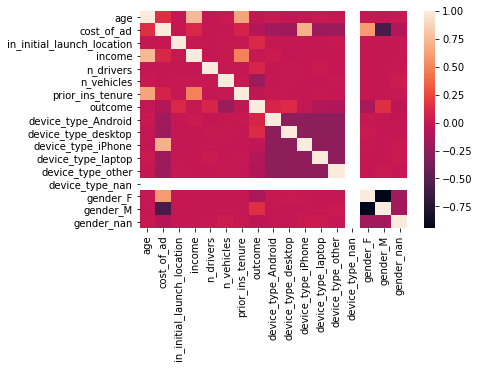

In [50]:
_ = sns.heatmap(df.corr())

In [51]:
df = df.drop(['gender_M', 'device_type_nan'], 1)

## Train Model

In [52]:
# Create Training Data
X = df.drop('outcome', 1)
y = df['outcome']

## Create training and validation sets

In [53]:
# Create a train and test set with a 20% holdout

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Train gradient boosting model

In [54]:
# Use a gradient boosting model for speed and accuracy

clf_lgbm = LGBMClassifier(
        n_estimators=300,
        num_leaves=15,
        colsample_bytree=.8,
        subsample=.8,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01
    )

clf_lgbm.fit(X_train, 
        y_train,
        eval_set= [(X_train, y_train), (X_test, y_test)], 
        eval_metric='auc', 
        verbose=0, 
        early_stopping_rounds=30
       )

LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0.01,
               n_estimators=300, num_leaves=15, reg_alpha=0.1, reg_lambda=0.1,
               subsample=0.8)

## Do k-fold cross-validation
to verify that these results from the model are consistent across 5 folds as a default value.

In [55]:
cv = cross_validate(clf_lgbm, X_test, y_test, cv=5)

cv['test_score']

array([0.9025, 0.875 , 0.885 , 0.905 , 0.8875])

In [56]:
def get_auc(model, data):
    """
    take in a model and DataFrame
    and return the auc score
    """
    scores = model.predict_proba(data)

    y_scores = [x[1] for x in scores]
    return roc_auc_score(y_test, y_scores)

print(get_auc(clf_lgbm, X_test))

0.8424252720888806


## Predict top 5 rows of Test Data

In [60]:
def process_data(path_to_test):
    test = pd.read_csv(path_to_test)
    # Create Null class for gender

    # iterate through categorical columns
    # and add dummies
    for col in ['device_type', 'gender']:
        test = add_dummy_columns(test, col)

    test = test.drop(['device_type',
                      'device_type_nan',
                      'gender_M',
                      'gender'
                      ], 1)
    return test

test = process_data('test.csv')
display(test.head())

,age,cost_of_ad,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,device_type_Android,device_type_desktop,device_type_iPhone,device_type_laptop,device_type_other,gender_F,gender_nan
0,34,0.005134,1,40376,1,3,7,0,0,1,0,0,0,0
1,53,0.005223,1,84511,1,1,11,0,1,0,0,0,1,0
2,46,0.004939,0,79322,1,1,4,0,0,0,1,0,0,0
3,36,0.004924,0,63295,1,2,0,1,0,0,0,0,1,0
4,28,0.005146,1,36170,1,3,3,0,1,0,0,0,0,0


In [61]:
set(df.drop('outcome', 1).columns) == set(test.columns)

True

In [62]:
clf_lgbm.predict(test.head())

array([0, 0, 0, 0, 0])